In [1]:
import os
import time
import argparse
import random
from functools import partial
from collections import namedtuple

In [2]:
from transformers import AutoTokenizer

/mnt/shared_home/smuckati/miniconda3/envs/relora_sft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import load_dataset, load_metric, DatasetDict

In [64]:
tokenizer = AutoTokenizer.from_pretrained("t5-small", use_fast=True)

In [4]:
# compute the length of the labels
tasks = ['cola', 'sst2', 'mrpc', 'qqp', 'mnli', 'qnli', 'rte', 'wnli']
tasks_to_labels = {
    'cola': ['unacceptable', 'acceptable'],
    'sst2': ['negative', 'positive'],
    'mrpc': ['not_equivalent', 'equivalent'],
    'qqp': ['not_duplicate', 'duplicate'],
    # processed differently as this is a regression task
    'sts-b': [],
    'mnli': ['entailment', 'neutral', 'contradiction'],
    'qnli': ['entailment', 'not_entailment'],
    'rte': ['entailment', 'not_entailment'],
    'wnli': ['not_entailment', 'entailment']
}

In [65]:
dataset_name = "glue"
for task in tasks:
    print(f"The task is {task}")
    dataset = load_dataset(dataset_name, task)
    labels = tasks_to_labels[task]
    for label in labels:
        print(label)
        label_tokens = tokenizer(label)
        print(label_tokens["input_ids"])
        input_ids = label_tokens["input_ids"]
        print(f"Tokenized length is {len(input_ids)}")

The task is cola
unacceptable
[29452, 1]
Tokenized length is 2
acceptable
[9961, 1]
Tokenized length is 2
The task is sst2
negative
[2841, 1]
Tokenized length is 2
positive
[1465, 1]
Tokenized length is 2
The task is mrpc
not_equivalent
[59, 834, 15, 1169, 15592, 1]
Tokenized length is 6
equivalent
[7072, 1]
Tokenized length is 2
The task is qqp
not_duplicate
[59, 834, 26, 413, 26221, 1]
Tokenized length is 6
duplicate
[19197, 1]
Tokenized length is 2
The task is mnli
entailment
[3, 35, 5756, 297, 1]
Tokenized length is 5
neutral
[7163, 1]
Tokenized length is 2
contradiction
[27252, 1]
Tokenized length is 2
The task is qnli
entailment
[3, 35, 5756, 297, 1]
Tokenized length is 5
not_entailment
[59, 834, 35, 5756, 297, 1]
Tokenized length is 6
The task is rte
entailment
[3, 35, 5756, 297, 1]
Tokenized length is 5
not_entailment
[59, 834, 35, 5756, 297, 1]
Tokenized length is 6
The task is wnli
not_entailment
[59, 834, 35, 5756, 297, 1]
Tokenized length is 6
entailment
[3, 35, 5756, 297, 

In [66]:
def glue(x, benchmark_name, label_names, feature_names=None, id_key='idx'):
    """Convert a dataset from glue to text2text examples.

    This function uses the feature names from the dataset to unpack examples into
    a format amenable for a text2text problem. For example, consider the Quora
    Question Pairs (QQP) benchmark, which would suggest
    benchmark_name="qqp"
    label_names=['not_duplicate', 'duplicate']
    For QQP, a typical example might look like
    {
        "question1": "Why do I easily get bored of my friends?",
        "question2": "Why do I get bored of friends so quickly?",
        "label": 1,
        "idx": 10,
    }

    This example would be transformed to
    {
        "inputs": (
            "qqp question1: Why do I easily get bored of my friends? question2: "
            "Why do I get bored of my friends so quickly?"
        ),
        "targets": "duplicate",
        "idx": 10,
    }

    Args:
        x: an example to process.
        benchmark_name: the name of the GLUE benchmark for this dataset.
        label_names: a list of label names corresponding to class index.
        feature_names: an optional ordered list of feature names. If provided,
        features will be ordered in this way in the output. If not provided, all
        features (except 'idx' and 'label') will be used, sorted by name.
        id_key: str, key for id in the dataset. If not provided, 'idx' will be used.
        if None, no id will be added to the dataset.

    Returns:
        A preprocessed example.
    """
    feature_keys = feature_names or sorted(set(x.keys()).difference(['label', 'idx']))
    strs_to_join = []
    for key in feature_keys:
        strs_to_join.append('{}:'.format(key))
        strs_to_join.append(x[key])
    strs_to_join.insert(0, benchmark_name)
    label_name = '<unk>' if x['label'] == -1 else label_names[x['label']]
    joined = ' '.join(strs_to_join)

    ex = {}
    ex['inputs'] = joined
    ex['targets'] = label_name

    return ex


In [67]:
def preprocess_function_decoder(examples):
        # add a separator between inputs and targets for the model to learn when to predict the targets
        inputs = examples['inputs'] + ":" + examples['targets']
        inputs = tokenizer(inputs, return_tensors='pt')

        return {'input_ids': len(inputs['input_ids'].squeeze(0))}

In [68]:
for task in tasks:
    print(f"The task is {task}")
    dataset = load_dataset(dataset_name, task)  
    glue_partial = partial(glue, benchmark_name=task, label_names=tasks_to_labels[task])
    column_names = dataset['train'].column_names
    dataset = dataset.map(glue_partial, remove_columns=column_names)
    old_columns = dataset['train'].column_names
    tokenized_dataset = dataset.map(preprocess_function_decoder, remove_columns=old_columns)
    len_ids = max([tokenized_dataset["train"][token_ids]["input_ids"] for token_ids in range(0, len(tokenized_dataset["train"]))])
    print(f"The maximum length inputs for {task} is: {len_ids}")


The task is cola


Map: 100%|██████████| 1063/1063 [00:00<00:00, 4579.87 examples/s]


The maximum length inputs for cola is: 54
The task is sst2


Map: 100%|██████████| 1821/1821 [00:00<00:00, 4154.31 examples/s]


The maximum length inputs for sst2 is: 93
The task is mrpc


Map: 100%|██████████| 1725/1725 [00:00<00:00, 2821.97 examples/s]


The maximum length inputs for mrpc is: 147
The task is qqp


Map: 100%|██████████| 390965/390965 [01:42<00:00, 3815.68 examples/s]


The maximum length inputs for qqp is: 361
The task is mnli


Map: 100%|██████████| 9847/9847 [00:02<00:00, 3390.39 examples/s]


The maximum length inputs for mnli is: 542
The task is qnli


Map: 100%|██████████| 5463/5463 [00:01<00:00, 2805.53 examples/s]


The maximum length inputs for qnli is: 669
The task is rte


Map: 100%|██████████| 3000/3000 [00:01<00:00, 2622.58 examples/s]


The maximum length inputs for rte is: 323
The task is wnli


Map: 100%|██████████| 146/146 [00:00<00:00, 2849.03 examples/s]

The maximum length inputs for wnli is: 132


In [74]:
output_text = "prediction</s><pad><pad><pad>not_entailment<pad><pad>"
decoded_labels = "not_entailment"

generated_strings = output_text.strip().lower().split(" ")
print(f"Generated string is {generated_strings}")

#decoded_labels = tokenizer.decode(labels[idx], skip_special_tokens=True)
label_index = -1
# you will always have one decoded_label even for strings like not_entailment
if decoded_labels in output_text:
    label_index = tasks_to_labels["rte"].index(decoded_labels)
    print(f"Label index is {label_index}")

Generated string is ['prediction</s><pad><pad><pad>not_entailment<pad><pad>']
Label index is 1


In [8]:
# get prompts from flan templates 
# https://github.com/google-research/FLAN/blob/main/flan/templates.py
import templates
from preprocessors import glue, stsb, string_to_float

In [9]:
tasks = ['cola', 'sst2', 'glue_mrpc', 'glue_qqp', 'mnli', 'qnli', 'rte', 'wnli']
for task in tasks:
    # pick the first prompt in the flan template
    prompt = templates.PATTERNS[task][0]
    print(f"The prompt for task {task} is {prompt}")

The prompt for task cola is ('Sentence: "{sentence}"\nWould a linguist rate this sentence to be acceptable linguistically?\n\n{options_}', '{answer}')
The prompt for task sst2 is ('Review:\n{sentence}\nIs this movie review sentence negative or positive?\n{options_}', '{answer}')
The prompt for task glue_mrpc is ('Here are two sentences:\n{sentence1}\n{sentence2}\nDo they have the same meaning?\n{options_}', '{answer}')
The prompt for task glue_qqp is ('{question1}\n{question2}\nWould you say that these questions are the same?\n{options_}', '{answer}')
The prompt for task mnli is ('Premise: {premise}\n\nHypothesis: {hypothesis}\n\nDoes the premise entail the hypothesis?\n\n{options_}', '{answer}')
The prompt for task qnli is ('Does the sentence "{sentence}" answer the question "{question}"\n\n{options_}', '{answer}')
The prompt for task rte is ('{premise}\n\nBased on the paragraph above can we conclude that "{hypothesis}"?\n\n{options_}', '{answer}')
The prompt for task wnli is ('If "{s

In [17]:
task_to_keys = {
    "cola": ("sentence"),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence"),
    "sts-b": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

In [36]:
from datasets import load_dataset, load_metric, DatasetDict
benchmark_name = 'sst2'
dataset = load_dataset('glue', benchmark_name)
smaller_dataset = DatasetDict()
for split in dataset.keys():
    subset_size = 10
    smaller_dataset[split] = dataset[split].shuffle(seed=42).select(range(subset_size))
dataset = smaller_dataset

data = smaller_dataset['train'][2]
print(f'{data}')

{'sentence': 'soulful and ', 'label': 1, 'idx': 60108}


In [39]:

label_names = tasks_to_labels[benchmark_name]
print(label_names)
feature_keys = task_to_keys[benchmark_name]
print(feature_keys)

if benchmark_name == 'rte':
    premise = data['sentence1']
    hypothesis = data['sentence2']
else:
    # create variables with the same name as the strings - will need it to fill in the template
    variables = task_to_keys.get(benchmark_name, ())
    variables = (variables,) if isinstance(variables, str) else variables
    print(variables)
    locals().update({var: data[var] for var in variables})

    if 'premise' not in locals():
        premise = ''
    if 'hypothesis' not in locals():
        hypothesis = ''

# find out how many labels are there
num_labels = len(tasks_to_labels[benchmark_name])
print(f"The number of labels are: {num_labels}")
if num_labels == 3:
    options_ = f'A) {label_names[0]}\nB){label_names[1]}\nC){label_names[2]}' # You can modify the options as needed
    if data['label'] == 0:
        answer = 'A'
    elif data['label'] == 1:
        answer = 'B'
    elif data['label'] == 2:
        answer = 'C'
elif num_labels == 2:
    options_ = f'A) {label_names[0]}\nB) {label_names[1]}' # You can modify the options as needed
    answer = 'A' if data['label'] == 0 else 'B' # Modify according to the label mapping
prompt_template = templates.PATTERNS[benchmark_name][0][0] # extract first prompt and since its a tuple extract string
print(f'Prompt is {prompt_template}')
filled_prompt = prompt_template.format(
    premise=premise,
    hypothesis=hypothesis,
    sentence=locals().get('sentence', ''),
    sentence1=locals().get('sentence1', ''),
    sentence2=locals().get('sentence2', ''),
    question=locals().get('question', ''),
    question1=locals().get('question1', ''),
    question2=locals().get('question2', ''),
    options_=options_,
)

template_filled = (filled_prompt, answer)
new_temp = filled_prompt + '\n' + answer

print(f'Template filled is {new_temp}')

['negative', 'positive']
sentence
('sentence',)
The number of labels are: 2
Prompt is Review:
{sentence}
Is this movie review sentence negative or positive?
{options_}
Template filled is Review:
soulful and 
Is this movie review sentence negative or positive?
A) negative
B) positive
B


In [61]:
import transformers
import datasets
from datasets import load_dataset, load_metric, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("t5-base", use_fast=True)
dataset = load_dataset('glue', 'sst2')



/mnt/shared_home/smuckati/miniconda3/envs/relora_sft/lib/python3.11/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [2]:
dataset['train'][0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [7]:
len(tokenizer(dataset['train'][0]['sentence']).input_ids)

9

In [10]:
def preprocess(examples):
    length = len(tokenizer(examples['sentence']).input_ids)
    return {'lengths': length}

In [12]:
new_dataset = dataset.map(
                    preprocess,
                    num_proc=8)

Map (num_proc=8): 100%|██████████| 1821/1821 [00:00<00:00, 9673.77 examples/s] 


In [18]:
len_list = new_dataset['train'][:]['lengths']

In [32]:
len(len_list)

67349

In [34]:
len([num for num in len_list if num > 60])

289

<Axes: ylabel='Count'>

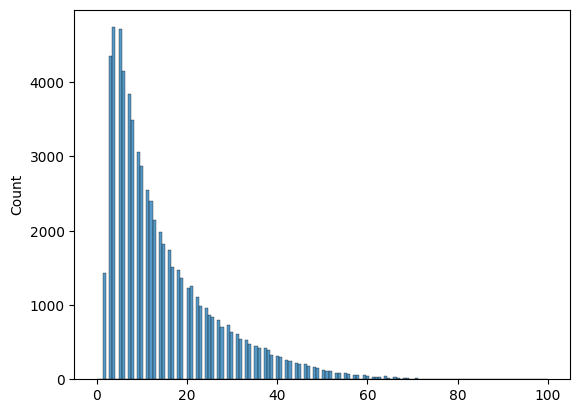

In [27]:
import seaborn as sns
sns.histplot(len_list, binrange=(0, 100))

In [62]:
sentence1_key, sentence2_key = ('sentence', None)

def preprocess_function(examples):
    # Tokenize the texts
    texts = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    ) 
    result = tokenizer(*texts, padding=False, max_length=512, truncation=True)

    # if "label" in examples:
    #     if label_to_id is not None:
    #         # Map labels to IDs (not necessary for GLUE tasks)
    #         result["labels"] = [label_to_id[l] for l in examples["label"]]
    #     else:
    #         # In all cases, rename the column to labels because the model will expect that.
    #         result["labels"] = examples["label"]
    
    #get the length of the tokenized inputs
    result['lengths'] = len(result['input_ids'])
    return result

In [63]:
processed_datasets = dataset.map(
    preprocess_function,
    batched=False,
    remove_columns=dataset["train"].column_names,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/872 [00:00<?, ? examples/s]

Running tokenizer on dataset: 100%|██████████| 872/872 [00:00<00:00, 4958.43 examples/s]


In [64]:
processed_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'lengths'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'lengths'],
        num_rows: 872
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'lengths'],
        num_rows: 1821
    })
})

In [65]:
processed_datasets['train'][1]

{'input_ids': [2579, 150, 3, 7820, 3, 6, 163, 5347, 15, 26, 23856, 7, 1],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'lengths': 13}

In [66]:
threshold = 60
def filter_by_length(example):
    return example['lengths'] > threshold

In [68]:
filtered_dataset = processed_datasets['train'].filter(filter_by_length)

In [71]:
filtered_dataset[1]

{'input_ids': [13, 392, 75, 63, 1],
 'attention_mask': [1, 1, 1, 1, 1],
 'lengths': 5}

In [78]:
processed_datasets['train'][7]

{'input_ids': [13, 392, 75, 63, 1],
 'attention_mask': [1, 1, 1, 1, 1],
 'lengths': 5}